In [1]:
%matplotlib widget
import contextily as cx
from matplotlib.pyplot import figure, draw, pause
from collections import OrderedDict
from scipy.interpolate import interpn
from xyzservices import TileProvider
from matplotlib.axes import Axes
from typing import List, Union, Tuple, Optional, Dict, Callable
import xarray as xa
import numpy as np
import os, logging, traceback, time
import rioxarray as rio
import matplotlib.pyplot as plt

log_file = os.path.expanduser('~/.spectraclass/logging/geospatial.log')
file_handler = logging.FileHandler(filename=log_file, mode='w')
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [2]:
result_dir = "/Users/tpmaxwel/Development/Data/raster/tiles"
SpectralDataset = f"{result_dir}/DESIS-HSI-L1C-DT0468853252_003-20200628T153803-V0210-SPECTRAL_IMAGE.nc"
dset = xa.open_dataset(SpectralDataset)
raster: xa.DataArray = dset['z']
classes = dict( water='blue', vegetation='green', urban='grey' )
band = 100

In [3]:
class Timer(object):
    def __init__(self):
        self.message = None
        self.t0 = None

    def log_timing(self, message):
        self.message = message
        return self

    @property
    def elapsed(self):
        return time.time()-self.t0

    def __enter__(self,*args):
        self.t0 = time.time()

    def __exit__(self,*args):
        logger.info( f" {self.message}: Exec in {self.elapsed} sec")

class CallbacksController(object):
    def __init__(self, ax, callbacks: Dict ):
        self.ax = ax
        self.callbacks = callbacks
        self.connect()

    def connect(self):
        for cid, cback in self.callbacks.items():
            self.ax.callbacks.connect( cid, cback )

    def disconnect(self):
        for cid in self.callbacks.keys():
            self.ax.callbacks.disconnect( cid )

    def __enter__(self):
        self.disconnect()

    def __exit__( self, *args ):
        self.connect()

class DynamicBasemap(object):

    def __init__(self, ax: Axes, source: TileProvider, **kwargs ):
        self.ax: Axes = ax
        self.source: TileProvider = source
        self.crs: str = kwargs.get('crs',None)
        self.timer = Timer()
        self.add_basemap( **kwargs )
        self.callbacks_control = CallbacksController( ax, dict( ylim_changed= self.on_lims_change ) )

    def on_lims_change( self, *args ):
        try:
            logger.info( f"EXEC lims_change callback" )
            t0 = time.time()
            self.update_basemap()
            logger.info( f"Completed lims_change callback in {time.time()-t0} sec" )
        except Exception as err:
            logger.info( f"Exception '{err}' in on_lims_change callback:" )
            logger.info( traceback.format_exc() )

    def reproject_bounds(self, left, right, bottom, top, s_crs, t_crs):
        from rasterio.warp import transform_bounds
        n_l, n_b, n_r, n_t = transform_bounds(s_crs, t_crs, left, bottom, right, top)
        return n_l, n_r, n_b, n_t

    def get_basemap_tile(self, xlim, ylim ) -> Tuple[ np.ndarray, Tuple[float] ]:
        from contextily.tile import bounds2img, warp_tiles
        if self.crs is not None:
            xmin, xmax, ymin, ymax = self.reproject_bounds(  xlim[0], xlim[1], ylim[0], ylim[1], self.crs, {"init": "epsg:3857"} )
        else:
            xmin, xmax, ymin, ymax = xlim[0], xlim[1], ylim[0], ylim[1]

        image, extent = self.get_tile_region( xmin, ymin, xmax, ymax, source=self.source )

        if self.crs is not None:
            image, extent = warp_tiles( image, extent, t_crs=self.crs )

        if image.shape[2] == 1: image = image[:, :, 0]
        return image, extent

    def get_tile_region( self, w, s, e, n, source=None ):
        from contextily.tile import _sm2ll, _process_source, _calculate_zoom, _validate_zoom, mt, _fetch_tile, _merge_tiles
        t0 = time.time()
        w, s = _sm2ll(w, s)
        e, n = _sm2ll(e, n)
        provider = _process_source(source)
        zoom = _calculate_zoom( w, s, e, n )
        zoom = _validate_zoom( zoom, provider )
        tiles = []
        arrays = []
        for t in mt.tiles(w, s, e, n, [zoom]):
            x, y, z = t.x, t.y, t.z
            tile_url = provider.build_url(x=x, y=y, z=z)
            image = _fetch_tile( tile_url, 0, 2 )
            tiles.append(t)
            arrays.append(image)
        merged, extent = _merge_tiles(tiles, arrays)
        # lon/lat extent --> Spheric Mercator
        west, south, east, north = extent
        left, bottom = mt.xy(west, south)
        right, top = mt.xy(east, north)
        extent = left, right, bottom, top
        logger.info( f"get_tile_region: zoom={zoom}, time = {time.time()-t0} sec" )
        return merged, extent

    def reinterp(self, data: np.ndarray, extent: Tuple, new_extent: Tuple, new_shape: Tuple):
        coords0 = OrderedDict( (f"C{iC}", np.linspace( extent[2*iC], extent[2*iC+1], data.shape[iC], False )) for iC in [0,1] )
        coords1 = { f"C{iC}": np.linspace( new_extent[2*iC], new_extent[2*iC+1], new_shape[iC], False ) for iC in [0,1] }
        for cv in [coords0,coords1]: cv["C2"] = range(data.shape[2])
        xdata = xa.DataArray( data, coords=coords0, dims=list(coords0.keys()) )
#        logger.info( f"reinterp: time = {time.time()-t0} sec" )
        return xdata.interp( coords1, assume_sorted=True )

#        return interpn( coords0, data, np.meshgrid( coords1 ), method='linear', bounds_error=False, fill_value=0.0 )

    def update_basemap( self ):
        xlim, ylim = self.ax.get_xlim(), self.ax.get_ylim()
        logger.info( f"update_basemap: xlim={xlim}, ylim={ylim}" )
        with self.callbacks_control:
            logger.info( f"get tile")
            image, extent = self.get_basemap_tile( xlim, ylim )
            basemap_data = self.reinterp( image, extent, xlim+ylim, self.basemap_shape )
            logger.info( f"update image, data shape = {basemap_data.shape}")
            self.basemap.set_data( basemap_data )
#            draw(); pause(0.01)

    def add_basemap( self, **kwargs ):
        xlim, ylim = self.ax.get_xlim(), self.ax.get_ylim()
        image, extent = self.get_basemap_tile( xlim, ylim )
        logger.info( f"add_basemap: xlim={xlim}, ylim={ylim}, shape={image.shape}, extent={extent}" )
        img = self.ax.imshow( image, extent=extent )
        self.ax.axis( xlim+ylim )
        self.basemap_shape = image.shape+tuple()
        self.basemap = img

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
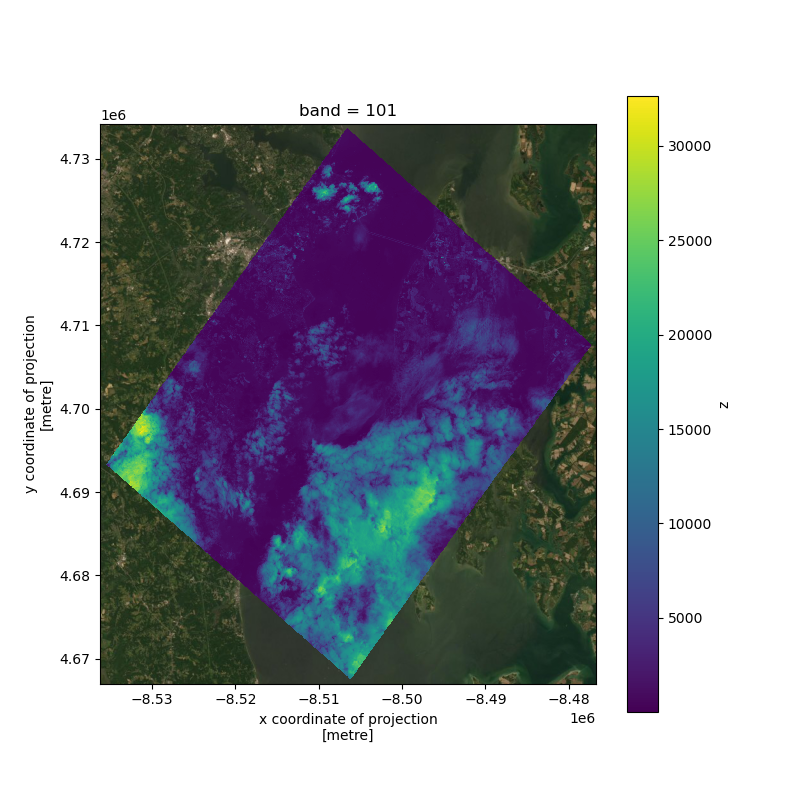

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8.0,8.0) )
raster[band].plot( ax=ax )
basemap = DynamicBasemap( ax, source=cx.providers.Esri.WorldImagery )
plt.show()